In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub
from tqdm.auto import tqdm

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
caption_file="/kaggle/input/flickr8k/captions.txt"
image_dir="/kaggle/input/flickr8k/Images/"

In [5]:
df = pd.read_csv(caption_file)

In [6]:
# Display sample data
print("\nSample data:")
print(df.head())


Sample data:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [7]:
# Create vocabulary
spacy_en = spacy.load("en_core_web_sm")

In [8]:
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return [token.text.lower() for token in spacy_en.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] = frequencies.get(word, 0) + 1

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.itos[idx] = word
                self.stoi[word] = idx
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

In [9]:
# Build vocabulary
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(df['caption'].tolist())

In [10]:
class FlickrDataset(Dataset):
    def __init__(self, df, vocab, transform, image_dir):
        self.df = df
        self.vocab = vocab
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df.iloc[idx]['caption']
        img_id = self.df.iloc[idx]['image']
        
        image = Image.open(os.path.join(self.image_dir, img_id)).convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        numericalized_caption = [self.vocab.stoi["<start>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<end>"])
        
        return image, torch.tensor(numericalized_caption)

In [11]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Split dataset
train_ids, test_ids = train_test_split(df['image'].unique(), test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

train_df = df[df['image'].isin(train_ids)]
val_df = df[df['image'].isin(val_ids)]
test_df = df[df['image'].isin(test_ids)]    

In [13]:
# Create datasets
train_dataset = FlickrDataset(train_df, vocab, transform, image_dir)
val_dataset = FlickrDataset(val_df, vocab, transform, image_dir)
test_dataset = FlickrDataset(test_df, vocab, transform, image_dir)

In [14]:
# Collate function for padding
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    padded_captions = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        padded_captions[i, :end] = cap[:end]
    return images, padded_captions, lengths

In [15]:
# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [16]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        
        # Freeze ResNet parameters
        for param in self.resnet.parameters():
            param.requires_grad_(False)

    def forward(self, images):
        # No need for torch.no_grad() since parameters are frozen
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.bn(self.embed(features))
        return features

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.num_layers = num_layers

    def forward(self, features, captions):
        """
        Parameters:
        - features: encoder output (batch_size, embed_size)
        - captions: target captions (batch_size, seq_len)
        
        Returns:
        - outputs: (batch_size, seq_len-1, vocab_size)
        """
        # Remove <end> token from inputs
        embeddings = self.embed(captions[:, :-1])  # (batch_size, seq_len-1, embed_size)
        
        # Use features as initial hidden state
        h0 = features.unsqueeze(0).repeat(self.num_layers, 1, 1)
        
        # Forward pass through GRU
        outputs, _ = self.gru(embeddings, h0)
        
        # Convert to vocabulary space
        outputs = self.linear(outputs)  # (batch_size, seq_len-1, vocab_size)
        return outputs

In [18]:
# Initialize models
embed_size = 512
hidden_size = 512
vocab_size = len(vocab)
num_epochs = 50

In [19]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

print(f"Encoder device: {next(encoder.parameters()).device}")
print(f"Decoder device: {next(decoder.parameters()).device}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Encoder device: cuda:0
Decoder device: cuda:0


In [20]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=3e-4)

In [ ]:
# # ### Step 7: Training Loop with Early Stopping
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Training
    encoder.train()
    decoder.train()
    total_loss = 0
    correct = 0
    total = 0
    
    
    # Initialize progress bar for training
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, captions, _ in train_pbar:
        images = images.to(device, non_blocking=True)
        captions = captions.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        features = encoder(images)
        outputs = decoder(features, captions)
        
        loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()
        
        # Update metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 2)
        mask = (captions[:, 1:] != 0)
        batch_correct = ((predicted == captions[:, 1:]) & mask).sum().item()
        batch_total = mask.sum().item()
        correct += batch_correct
        total += batch_total
        
        # Update progress bar
        current_loss = total_loss / (train_pbar.n + 1e-5)
        current_acc = correct / (total + 1e-5)
        train_pbar.set_postfix({
            'loss': f'{current_loss:.3f}',
            'acc': f'{current_acc:.2%}',
            'progress': f'{(train_pbar.n+1)/len(train_loader):.1%}'
        })

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    encoder.eval()
    decoder.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    # Initialize progress bar for validation
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, captions, _ in val_pbar:
            images = images.to(device, non_blocking=True)
            captions = captions.to(device, non_blocking=True)
            
            features = encoder(images)
            outputs = decoder(features, captions)
            
            loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].contiguous().view(-1))
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 2)
            mask = (captions[:, 1:] != 0)
            batch_correct = ((predicted == captions[:, 1:]) & mask).sum().item()
            batch_total = mask.sum().item()
            val_correct += batch_correct
            val_total += batch_total
            
            # Update validation progress
            val_pbar.set_postfix({
                'progress': f'{(val_pbar.n+1)/len(val_loader):.1%}'
            })
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total if val_total > 0 else 0
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(encoder.state_dict(), 'best_encoder.pth')
        torch.save(decoder.state_dict(), 'best_decoder.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break
    
    # Print epoch summary
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.2%}')
    print(f'Val Loss: {val_loss:.4f} | Acc: {val_acc:.2%}')
    print('-'*50)

Epoch 1/50 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch [1/50]
Train Loss: 3.3902 | Acc: 37.54%
Val Loss: 2.9086 | Acc: 41.58%
--------------------------------------------------


Epoch 2/50 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch [2/50]
Train Loss: 2.6338 | Acc: 43.99%
Val Loss: 2.7009 | Acc: 43.58%
--------------------------------------------------


Epoch 3/50 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 3/50 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>    Exception ignored in: 
: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>self._shutdown_workers()can


Epoch [3/50]
Train Loss: 2.3647 | Acc: 47.09%
Val Loss: 2.6314 | Acc: 44.29%
--------------------------------------------------


Epoch 4/50 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch [4/50]
Train Loss: 2.1708 | Acc: 49.47%
Val Loss: 2.6091 | Acc: 44.21%
--------------------------------------------------


Epoch 5/50 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Epoch 5/50 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch [5/50]
Train Loss: 2.0144 | Acc: 51.76%
Val Loss: 2.6078 | Acc: 44.28%
--------------------------------------------------


Epoch 6/50 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>self._shutdown_workers()Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
            if w.is_alive():  File "/usr/local/li

Epoch 6/50 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch [6/50]
Train Loss: 1.8775 | Acc: 53.83%
Val Loss: 2.6370 | Acc: 44.40%
--------------------------------------------------


Epoch 7/50 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch [7/50]
Train Loss: 1.7591 | Acc: 55.93%
Val Loss: 2.6637 | Acc: 43.87%
--------------------------------------------------


Epoch 8/50 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    self._shutdown_workers()
<function _Multi

Epoch 8/50 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch [8/50]
Train Loss: 1.6507 | Acc: 57.83%
Val Loss: 2.7004 | Acc: 43.28%
--------------------------------------------------


Epoch 9/50 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    Exception ignored in: if w.is_aliv

Epoch 9/50 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch [9/50]
Train Loss: 1.5526 | Acc: 59.70%
Val Loss: 2.7330 | Acc: 43.26%
--------------------------------------------------


Epoch 10/50 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 10/50 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c28be7f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Early stopping at epoch 10


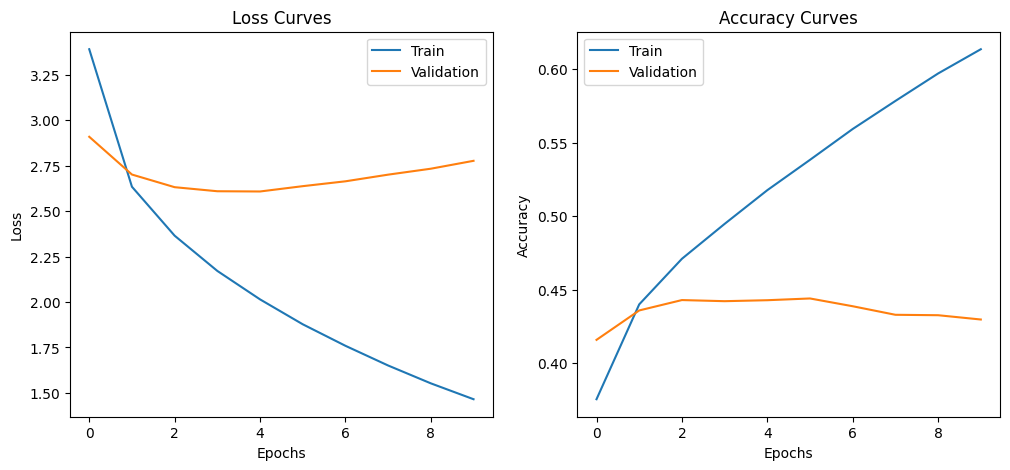

In [22]:
# ### Step 8: Plot Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# ### Step 9: Sample Predictions
def generate_caption(image_path, encoder, decoder, vocab, max_length=20):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        features = encoder(image)
        inputs = torch.tensor([vocab.stoi['<start>']]).to(device)
        hidden = features.unsqueeze(0)
        
        caption = []
        for _ in range(max_length):
            embeddings = decoder.embed(inputs.unsqueeze(0))
            output, hidden = decoder.gru(embeddings, hidden)
            output = decoder.linear(output.squeeze(0))
            predicted = output.argmax(1)
            
            inputs = predicted
            word = vocab.itos[predicted.item()]
            if word == '<end>':
                break
            caption.append(word)
    
    return ' '.join(caption)

In [27]:
# Load best models
encoder.load_state_dict(torch.load('best_encoder.pth'))
decoder.load_state_dict(torch.load('best_decoder.pth'))

<ipython-input-27-aed678433a0a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('best_encoder.pth'))
<ipython-input-27-aed678433a0a>:3: F

<All keys matched successfully>

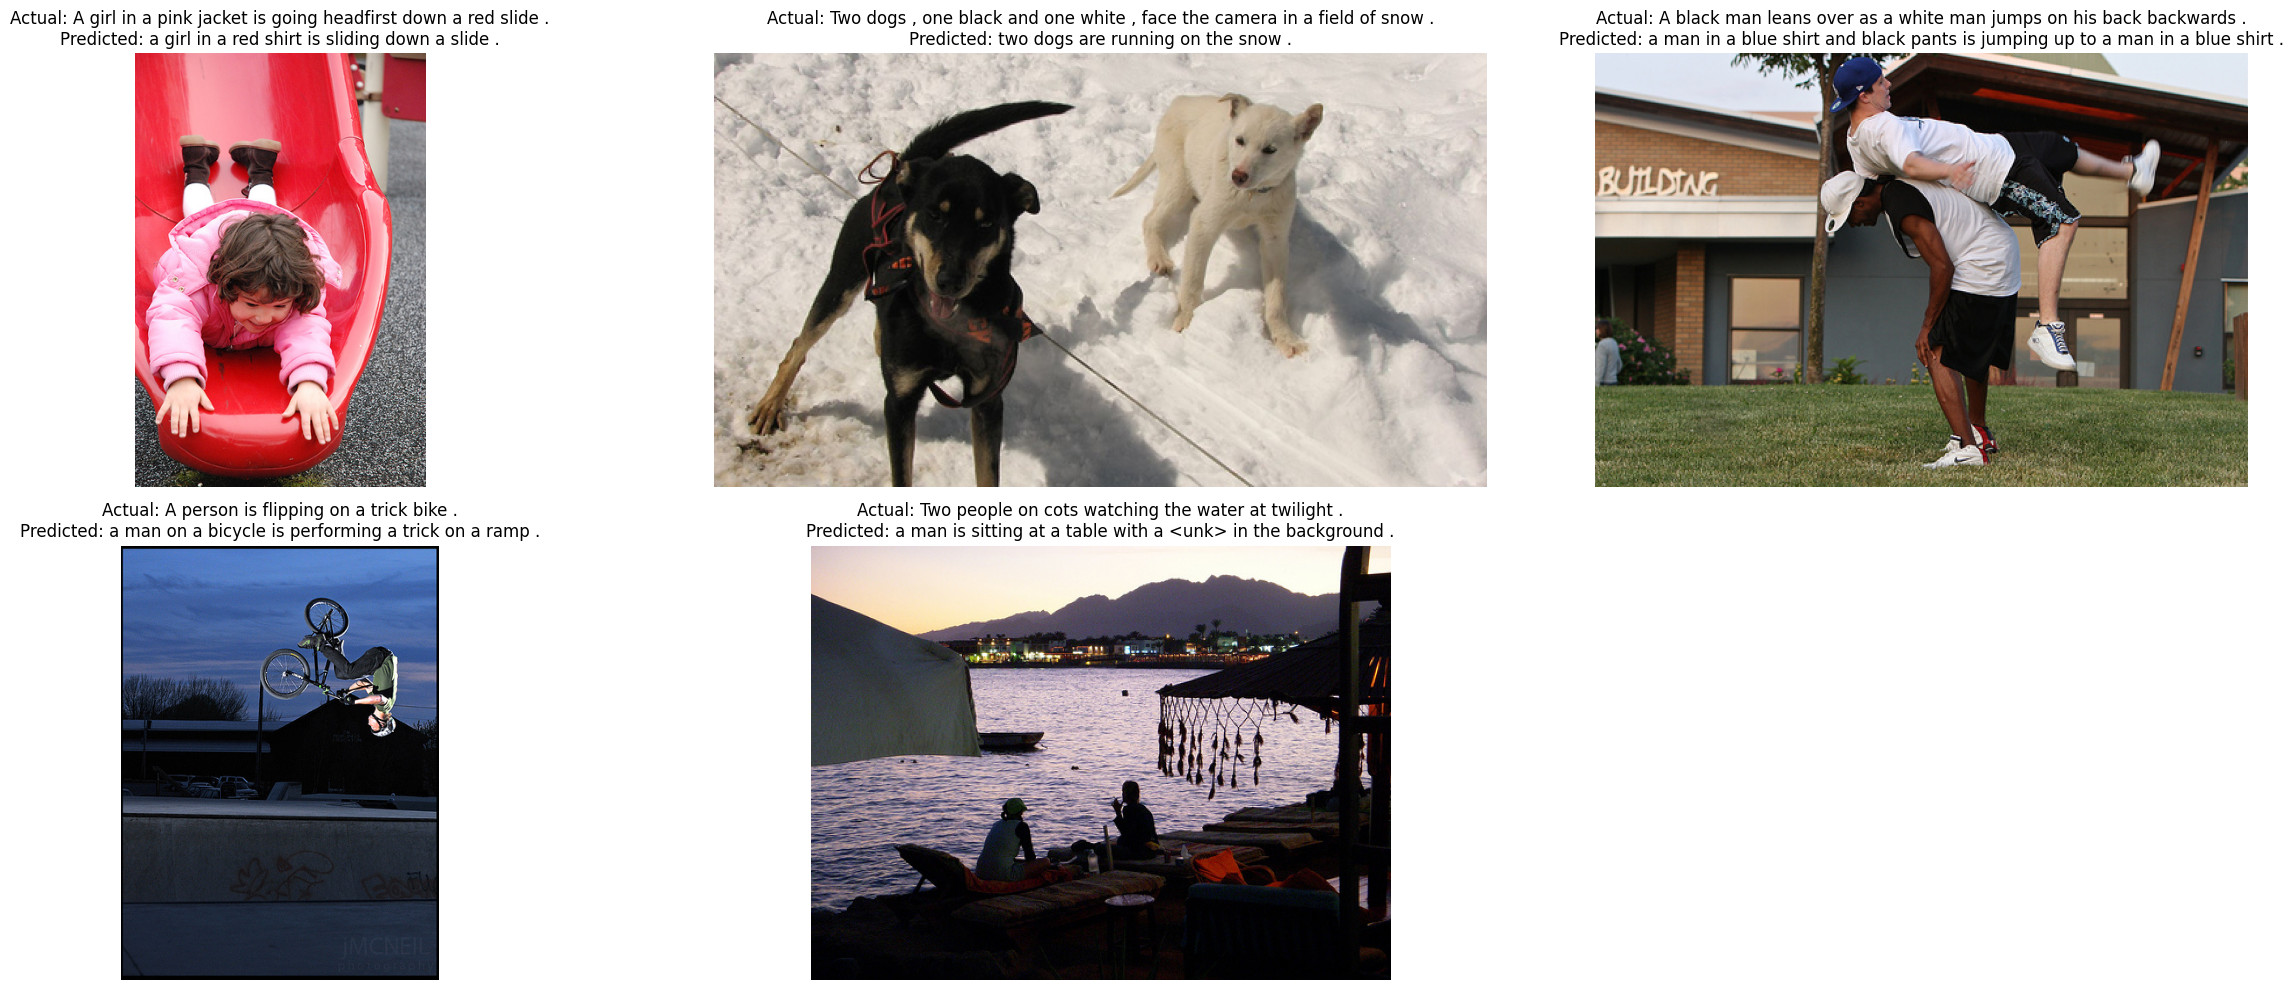

In [31]:
# Display sample predictions
sample_df = test_df.sample(5)
plt.figure(figsize=(25, 10))
for i, (idx, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(image_dir, row['image'])
    actual_caption = row['caption']
    predicted_caption = generate_caption(img_path, encoder, decoder, vocab)
    
    plt.subplot(2, 3, i+1)
    image = Image.open(img_path)
    plt.imshow(image)
    plt.title(f'Actual: {actual_caption}\nPredicted: {predicted_caption}')
    plt.axis('off')

plt.tight_layout()
plt.show()